In [ ]:
#bsub -nnodes 4 -Ip -XF -W 600 /bin/bash
#!lrun -T1 hostname | sort | awk '{print $1}'| sed "s/^/'/;s/$/',/"
#!bjobs -X

In [1]:
allocated_hosts = ['lassen121','lassen121',
'lassen126',
'lassen138',
'lassen144',
'lassen200',
'lassen202',
'lassen203',
'lassen204',
'lassen246',
'lassen359',
'lassen39',
'lassen422',
'lassen455',
'lassen467',
'lassen468',
'lassen51',
'lassen53',
'lassen530',
'lassen531',
'lassen532',
'lassen533',
'lassen55',
'lassen576',
'lassen58',
'lassen60',
'lassen62',
'lassen625',
'lassen723',
'lassen725',
'lassen751',
'lassen783',
'lassen796']
allocated_hosts_str = " ".join(allocated_hosts)
print(allocated_hosts_str)

lassen121 lassen121 lassen126 lassen138 lassen144 lassen200 lassen202 lassen203 lassen204 lassen246 lassen359 lassen39 lassen422 lassen455 lassen467 lassen468 lassen51 lassen53 lassen530 lassen531 lassen532 lassen533 lassen55 lassen576 lassen58 lassen60 lassen62 lassen625 lassen723 lassen725 lassen751 lassen783 lassen796


In [2]:
for host in allocated_hosts:
    print("ssh ",host," \"ps -aef | grep dask | grep -v grep | awk {'print \$2'} | xargs kill -9\"; ", end="")

ssh  lassen121  "ps -aef | grep dask | grep -v grep | awk {'print \$2'} | xargs kill -9"; ssh  lassen121  "ps -aef | grep dask | grep -v grep | awk {'print \$2'} | xargs kill -9"; ssh  lassen126  "ps -aef | grep dask | grep -v grep | awk {'print \$2'} | xargs kill -9"; ssh  lassen138  "ps -aef | grep dask | grep -v grep | awk {'print \$2'} | xargs kill -9"; ssh  lassen144  "ps -aef | grep dask | grep -v grep | awk {'print \$2'} | xargs kill -9"; ssh  lassen200  "ps -aef | grep dask | grep -v grep | awk {'print \$2'} | xargs kill -9"; ssh  lassen202  "ps -aef | grep dask | grep -v grep | awk {'print \$2'} | xargs kill -9"; ssh  lassen203  "ps -aef | grep dask | grep -v grep | awk {'print \$2'} | xargs kill -9"; ssh  lassen204  "ps -aef | grep dask | grep -v grep | awk {'print \$2'} | xargs kill -9"; ssh  lassen246  "ps -aef | grep dask | grep -v grep | awk {'print \$2'} | xargs kill -9"; ssh  lassen359  "ps -aef | grep dask | grep -v grep | awk {'print \$2'} | xargs kill -9"; ssh  lasse

In [4]:
import math
num_cores = 4
workers_per_node = 4
threads_per_worker = int(math.floor(num_cores / workers_per_node))
memory_per_worker = int(math.floor(256/workers_per_node))
print(workers_per_node,threads_per_worker,memory_per_worker )

4 1 64


In [5]:
from dask.distributed import SSHCluster
cluster = SSHCluster(
    allocated_hosts,
    connect_options={"known_hosts": None},
    worker_options={"nthreads": threads_per_worker, 'nprocs':workers_per_node, 'memory_limit': '{}GB'.format(memory_per_worker), "local_directory":'/tmp/haridev'},
    scheduler_options={"port": 8780, "dashboard_address": ":8797"}  
)

distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at: tcp://192.168.128.121:8780
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://192.168.128.121:33731'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://192.168.128.121:40007'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://192.168.128.121:33507'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://192.168.128.121:36123'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://192.168.130.215:36123'
distributed.deploy.ssh - IN

In [6]:
#cluster.close()

In [34]:
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
from dask.distributed import Client, wait
import matplotlib.pyplot as plt
import numpy as np
import concurrent
import concurrent.futures
from concurrent.futures import ThreadPoolExecutor

In [8]:
#cluster = LocalCluster()

In [9]:
#client = Client(cluster)
client = Client("{}:8780".format(allocated_hosts[0]))

In [10]:
client

<Client: 'tcp://192.168.128.121:8780' processes=128 threads=128, memory=7.45 TiB>

In [11]:
#client.shutdown()
#cluster.close()

In [12]:
def timer(func):
    @functools.wraps(func)
    def wrapper_timer(*args, **kwargs):
        tic = time.perf_counter()
        value = func(*args, **kwargs)
        toc = time.perf_counter()
        elapsed_time = toc - tic
        print(f"Elapsed time: {elapsed_time:0.4f} seconds")
        return value
    return wrapper_timer

In [13]:
def thread_print(string):
    print(f'{string}\n', end='')
def thread_process( num_ranks, func, start=0, list_range=[], workers=40):
    with ThreadPoolExecutor(max_workers = workers) as executor:
        if len(list_range) == 0:
            list_range = range(start, num_ranks) 
        future_gen = {executor.submit(func, rank): rank for rank in list_range}
        for future in concurrent.futures.as_completed(future_gen):
            rank = future_gen[future]
            try:
                data = future.result()
            except Exception as exc:
                thread_print('%r generated an exception: %s' % (rank, exc))
            else:
                thread_print('%r data computed' % (rank))

In [14]:
parquet_folder="/p/gpfs1/haridev/parquet/lbann-cosmoflow-32-trace-3"

In [15]:
num_ranks = 128

In [16]:
pbar = ProgressBar()
pbar.register()

### process dataset per rank

In [17]:
ddf = dd.read_parquet("{}/*.parquet".format(parquet_folder), engine="pyarrow-dataset")

In [18]:
ddf.npartitions

539

In [19]:
#client.cancel(ddf)

In [20]:
ddf.columns

Index(['index', 'rank', 'thread_id', 'cat', 'tstart', 'tend', 'func_id',
       'level', 'arg_count', 'args_1', 'args_2', 'args_3', 'args_4', 'args_5',
       'args_6', 'args_7', 'args_8', 'args_9', 'args_10'],
      dtype='object')

In [21]:
#ddf[0].head()

In [22]:
ddf = ddf[(ddf['level'] == 0) | ddf['cat'].isin([0,1,3])]
#ddf = ddf.persist()

In [23]:
io_ddf = ddf[ddf['cat'].isin([0,1,3])]
exclude_dirs = [".pyc", "/usr","/g/g92/haridev/.nccl.conf"]
for directory in exclude_dirs:
    io_ddf = io_ddf[~io_ddf['args_1'].str.contains(directory)]
#io_ddf[rank] = io_ddf[rank].persist()
mpi_ddf = ddf[ddf['cat'] == 2]
#mpi_ddf[rank] = mpi_ddf[rank].persist()
trace_ddf = ddf[ddf['cat'] == 4]

In [24]:
io_ddf.columns

Index(['index', 'rank', 'thread_id', 'cat', 'tstart', 'tend', 'func_id',
       'level', 'arg_count', 'args_1', 'args_2', 'args_3', 'args_4', 'args_5',
       'args_6', 'args_7', 'args_8', 'args_9', 'args_10'],
      dtype='object')

In [25]:
open_condition = io_ddf['func_id'].str.contains("open")
mpi_condition = io_ddf['func_id'].str.contains("MPI")
read_condition = io_ddf['func_id'].isin(["read", "pread", "pread64", "readv"])
fread_condition = io_ddf['func_id'].isin(["fread"])
close_condition = io_ddf['func_id'].str.contains('close')
write_condition = io_ddf['func_id'].isin(["write", "pwrite", "pwrite64","writev"])
fwrite_condition = io_ddf['func_id'].isin(["fwrite"])
readdir_condition = io_ddf['func_id'].isin(["readdir"])

In [26]:
io_ddf['filename'] = ""
io_ddf['filename'] = io_ddf['filename'].mask(open_condition & ~mpi_condition, io_ddf['args_1'])
io_ddf['filename'] = io_ddf['filename'].mask(open_condition & mpi_condition, io_ddf['args_2'])
io_ddf['filename'] = io_ddf['filename'].mask(close_condition, io_ddf['args_1'])
io_ddf['filename'] = io_ddf['filename'].mask(read_condition, io_ddf['args_1'])
io_ddf['filename'] = io_ddf['filename'].mask(fread_condition, io_ddf['args_4'])
io_ddf['filename'] = io_ddf['filename'].mask(write_condition, io_ddf['args_1'])
io_ddf['filename'] = io_ddf['filename'].mask(fwrite_condition, io_ddf['args_4'])

In [27]:
io_ddf['size'] = "0"
io_ddf['count'] = "1"
io_ddf['size'] = io_ddf['size'].mask(read_condition , io_ddf['args_3'])
io_ddf['size'] = io_ddf['size'].mask(fread_condition, io_ddf['args_3'])
io_ddf['count'] = io_ddf['count'].mask(fread_condition, io_ddf['args_2'])
io_ddf['size'] = io_ddf['size'].mask(write_condition, io_ddf['args_3'])
io_ddf['size'] = io_ddf['size'].mask(fwrite_condition, io_ddf['args_3'])
io_ddf['count'] = io_ddf['count'].mask(fwrite_condition, io_ddf['args_2'])

In [28]:
io_ddf['size'] = io_ddf['size'].mask(readdir_condition , "0")
io_ddf['count'] = io_ddf['count'].mask(readdir_condition , "1")

In [29]:
io_ddf = io_ddf.astype({'size': 'int32','count': 'int32'})

In [30]:
io_ddf['size'] = io_ddf['size'] * io_ddf['count']

In [31]:
io_ddf = io_ddf.persist()

In [35]:
wait(io_ddf)

DoneAndNotDoneFutures(done={<Future: finished, type: pandas.core.frame.DataFrame, key: ('assign-108e48b77100d6909e5e929ed1847adc', 332)>, <Future: finished, type: pandas.core.frame.DataFrame, key: ('assign-108e48b77100d6909e5e929ed1847adc', 344)>, <Future: finished, type: pandas.core.frame.DataFrame, key: ('assign-108e48b77100d6909e5e929ed1847adc', 213)>, <Future: finished, type: pandas.core.frame.DataFrame, key: ('assign-108e48b77100d6909e5e929ed1847adc', 225)>, <Future: finished, type: pandas.core.frame.DataFrame, key: ('assign-108e48b77100d6909e5e929ed1847adc', 112)>, <Future: finished, type: pandas.core.frame.DataFrame, key: ('assign-108e48b77100d6909e5e929ed1847adc', 471)>, <Future: finished, type: pandas.core.frame.DataFrame, key: ('assign-108e48b77100d6909e5e929ed1847adc', 417)>, <Future: finished, type: pandas.core.frame.DataFrame, key: ('assign-108e48b77100d6909e5e929ed1847adc', 445)>, <Future: finished, type: pandas.core.frame.DataFrame, key: ('assign-108e48b77100d6909e5e929e

In [36]:
all_filenames = io_ddf[io_ddf['filename'].str.contains('/p/gpfs1')]['filename'].unique().compute()

In [37]:
len(all_filenames)

644773

In [38]:
relevant_filenames = all_filenames.to_numpy()

In [51]:
file_df = io_ddf[io_ddf['filename'].isin(relevant_filenames)][['rank','filename', 'func_id','size', 'tstart', 'tend']].compute()

In [52]:
correct_dur = ((file_df['tend'] - file_df['tstart']) > 0)
file_df['bandwidth'] = -100
file_df['bandwidth'] = file_df['bandwidth'].mask(correct_dur, file_df['size']*1.0/(file_df['tend'] - file_df['tstart'])/1024.0/1024.0)

In [53]:
file_df

,rank,filename,func_id,size,tstart,tend,bandwidth
711,0,/p/gpfs1/haridev/software/lbann/applications/p...,open64,0,18.590284,18.590332,0.000000
844,0,/p/gpfs1/haridev/software/lbann/applications/p...,read,8192,18.649136,18.670824,0.360215
13312,0,/p/gpfs1/haridev/software/lbann/applications/p...,read,8192,28.456818,28.456837,409.600000
21344,0,/p/gpfs1/haridev/software/lbann/applications/p...,read,8192,36.021835,36.021847,682.666667
21346,0,/p/gpfs1/haridev/software/lbann/applications/p...,close,0,36.022255,36.022263,0.000000
...,...,...,...,...,...,...,...
7991460,127,/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniv...,pread,2097152,2147.483643,2147.483643,-100.000000
7991462,127,/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniv...,pread,2097152,2147.483643,2147.483643,-100.000000
7991466,127,/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniv...,pread,512,2147.483643,2147.483643,-100.000000
7991469,127,/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniv...,pread,16,2147.483643,2147.483643,-100.000000


In [54]:
file_df[file_df['func_id'].str.contains('read')]

,rank,filename,func_id,size,tstart,tend,bandwidth
844,0,/p/gpfs1/haridev/software/lbann/applications/p...,read,8192,18.649136,18.670824,0.360215
13312,0,/p/gpfs1/haridev/software/lbann/applications/p...,read,8192,28.456818,28.456837,409.600000
21344,0,/p/gpfs1/haridev/software/lbann/applications/p...,read,8192,36.021835,36.021847,682.666667
25855,0,/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniv...,pread64,8,2147.483643,2147.483643,-100.000000
25856,0,/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniv...,pread64,16,2147.483643,2147.483643,-100.000000
...,...,...,...,...,...,...,...
7991458,127,/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniv...,pread,2097152,2147.483643,2147.483643,-100.000000
7991460,127,/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniv...,pread,2097152,2147.483643,2147.483643,-100.000000
7991462,127,/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniv...,pread,2097152,2147.483643,2147.483643,-100.000000
7991466,127,/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniv...,pread,512,2147.483643,2147.483643,-100.000000


/p/gpfs1/haridev/software/lbann/applications/physics/cosmology/cosmoflow/20210908_120926_lbann_cosmoflow/experiment.prototext


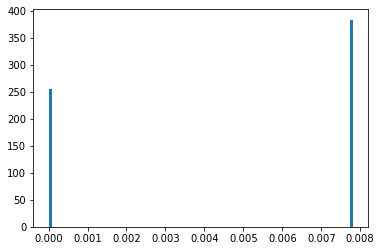

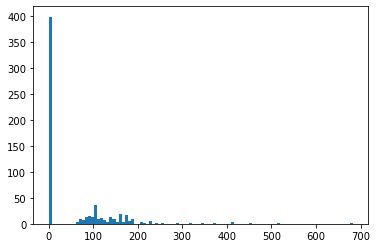

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a10000668_0_0_0_float.hdf5


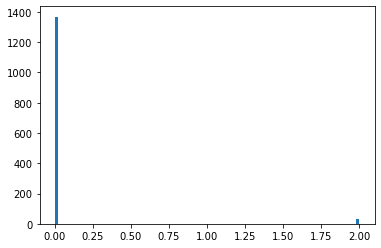

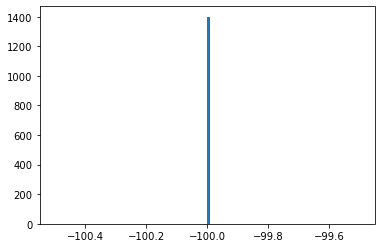

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a6981523_0_0_0_float.hdf5


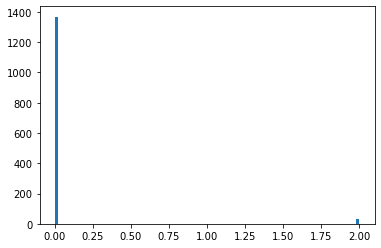

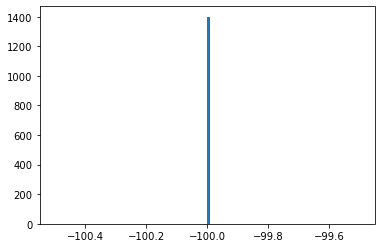

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a8515541_0_0_0_float.hdf5


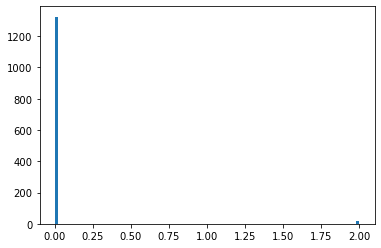

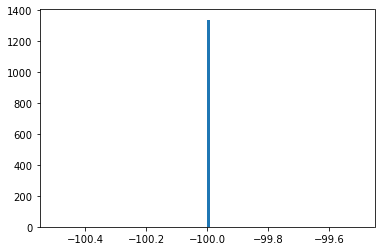

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a13383679_3_2_0_float.hdf5


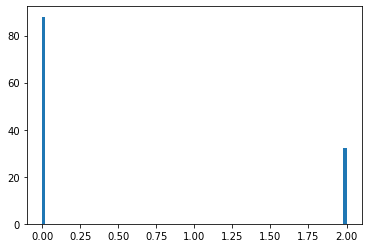

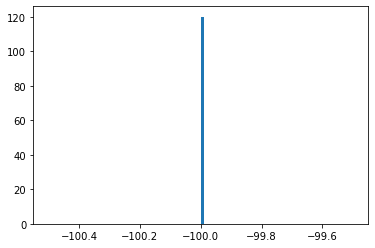

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a6312225_3_1_0_float.hdf5


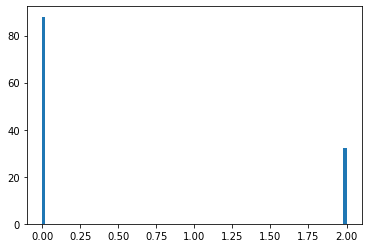

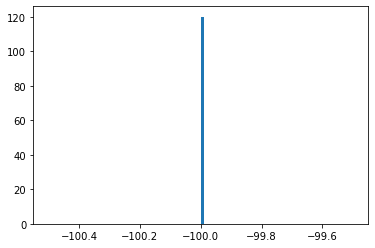

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a444662_2_1_1_float.hdf5


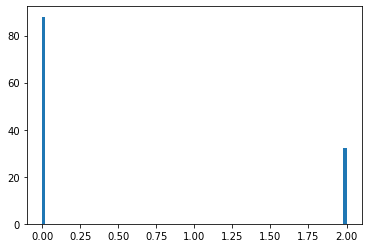

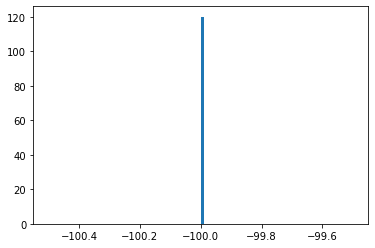

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a11327158_2_3_1_float.hdf5


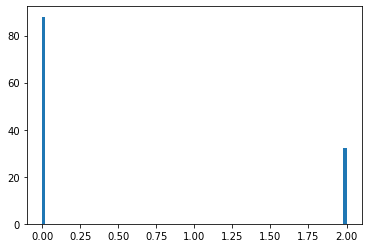

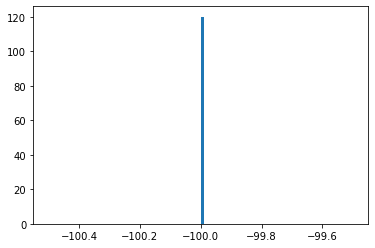

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a12528590_0_3_0_float.hdf5


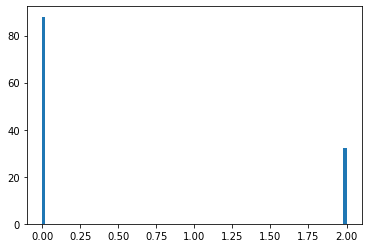

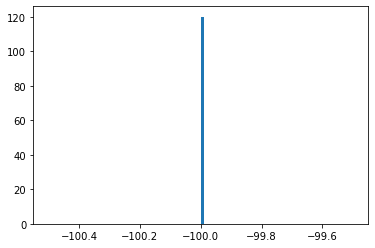

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a2203550_1_0_2_float.hdf5


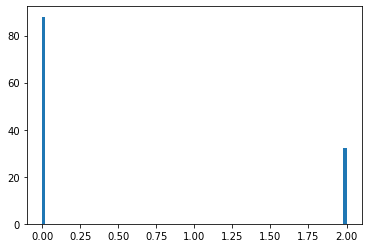

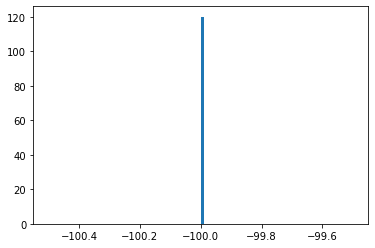

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a1247205_0_0_3_float.hdf5


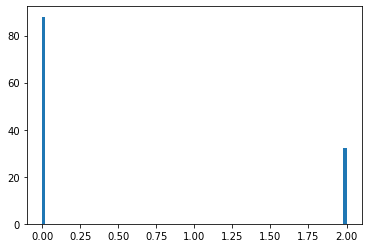

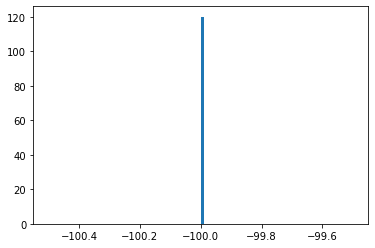

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a14914341_3_0_3_float.hdf5


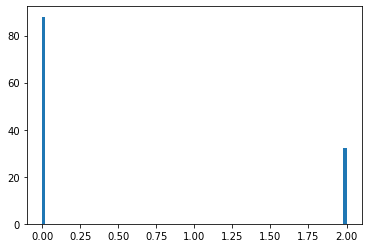

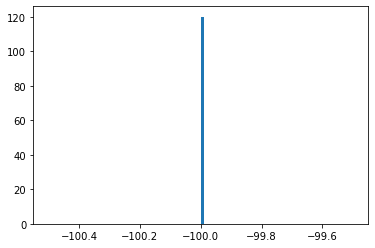

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a1799235_1_3_2_float.hdf5


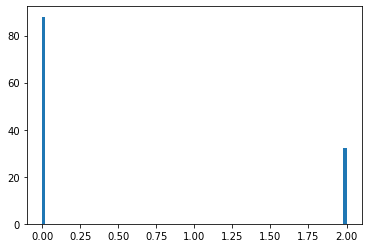

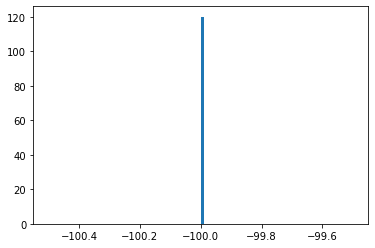

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a6281891_0_2_3_float.hdf5


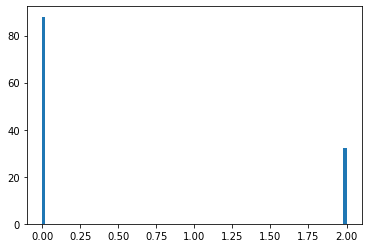

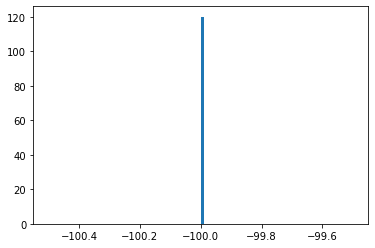

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a2905575_2_3_0_float.hdf5


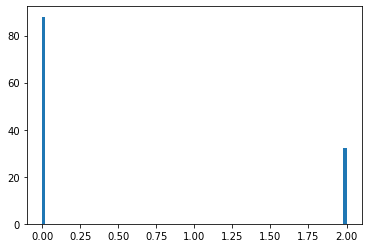

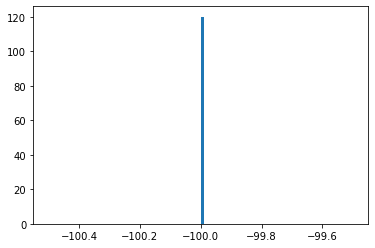

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a10131921_1_3_0_float.hdf5


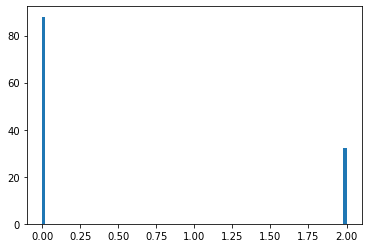

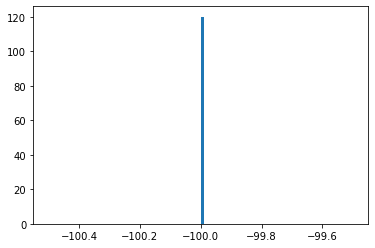

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a12663761_2_2_1_float.hdf5


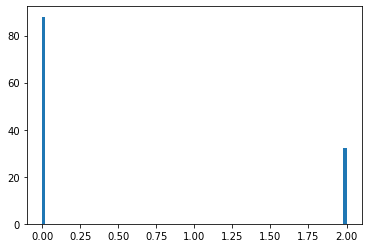

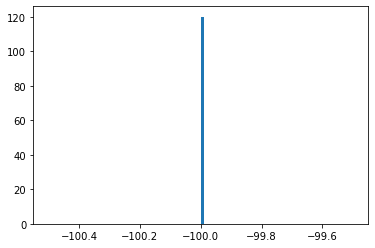

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a572689_3_3_0_float.hdf5


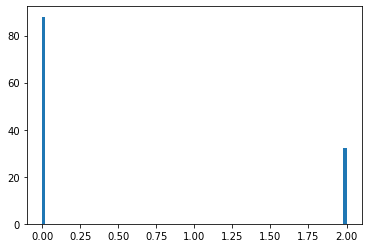

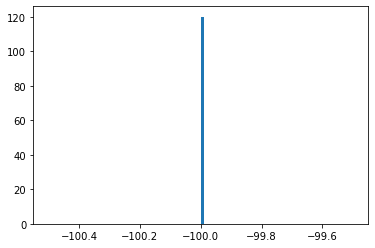

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a14811255_2_1_1_float.hdf5


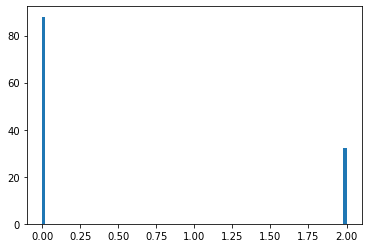

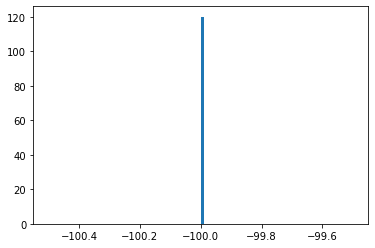

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a3652763_2_2_0_float.hdf5


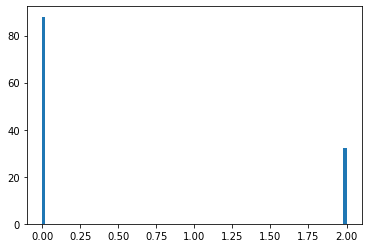

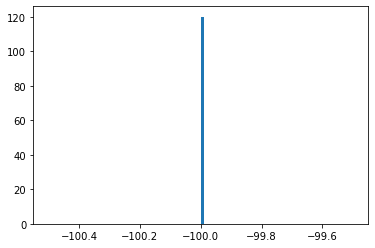

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a2915047_1_3_3_float.hdf5


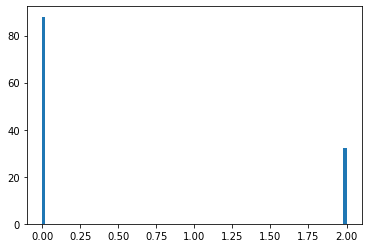

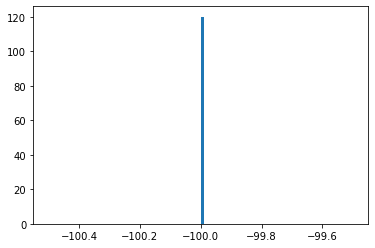

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a12294615_3_2_3_float.hdf5


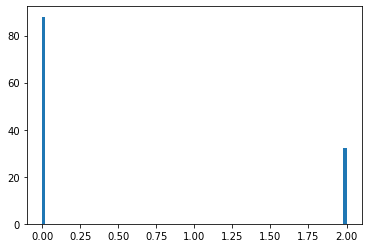

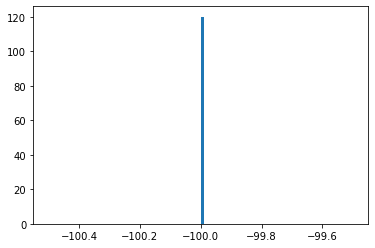

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a2671315_2_0_2_float.hdf5


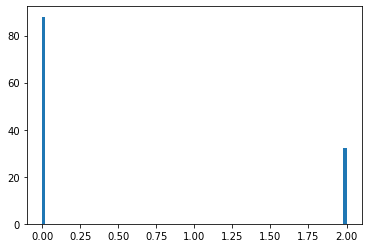

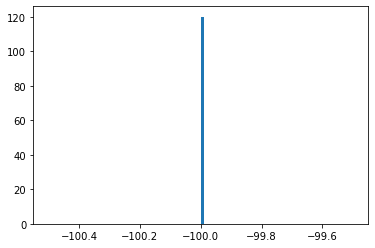

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a13179063_1_3_2_float.hdf5


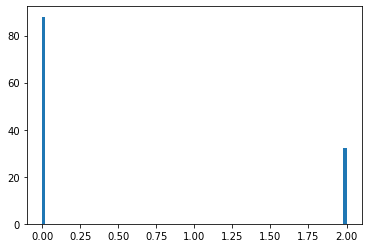

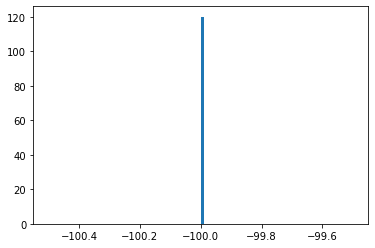

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a14076581_0_2_0_float.hdf5


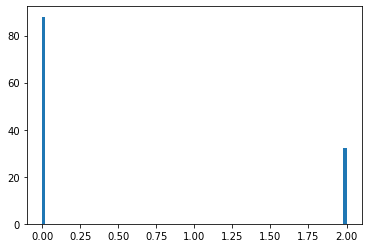

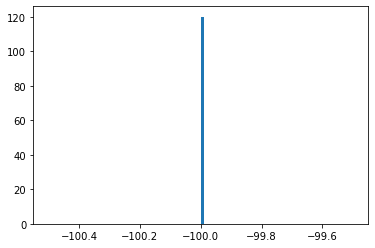

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a15834683_2_3_2_float.hdf5


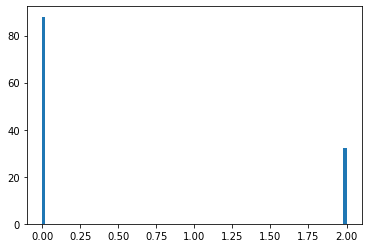

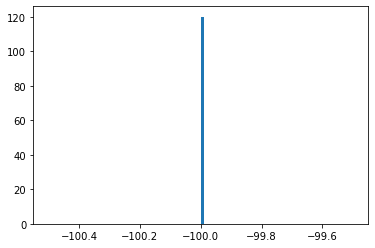

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a13148935_0_1_1_float.hdf5


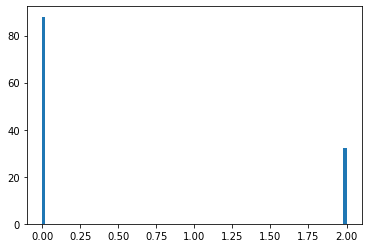

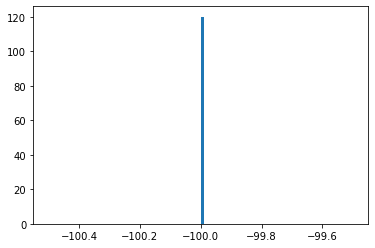

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a3690247_1_2_1_float.hdf5


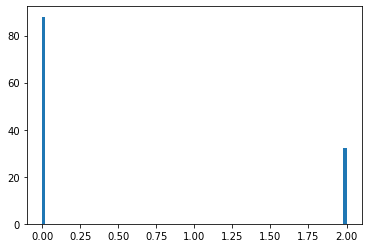

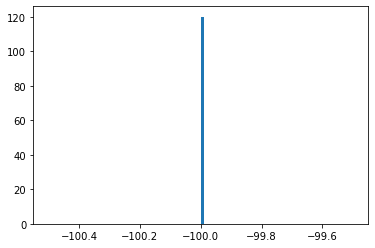

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a13506648_3_1_1_float.hdf5


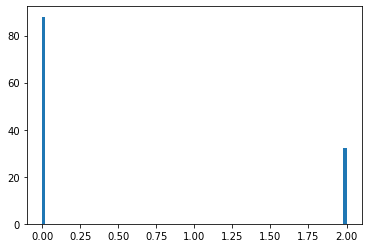

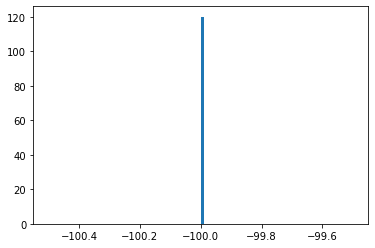

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a13319522_1_0_1_float.hdf5


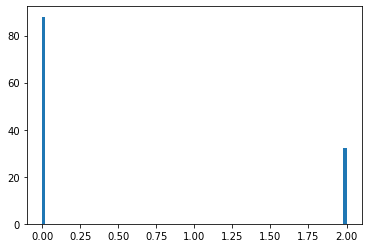

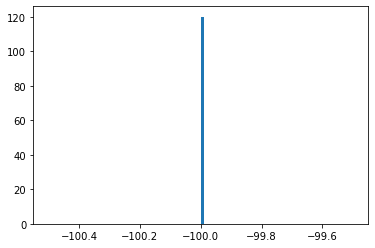

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a14921288_2_3_1_float.hdf5


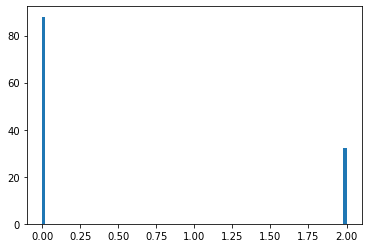

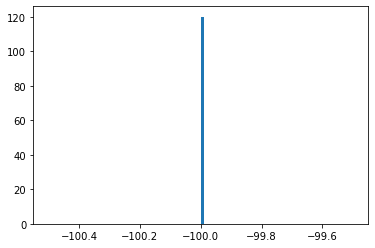

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a16393290_0_1_3_float.hdf5


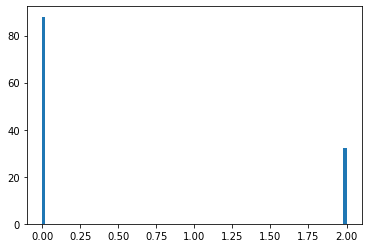

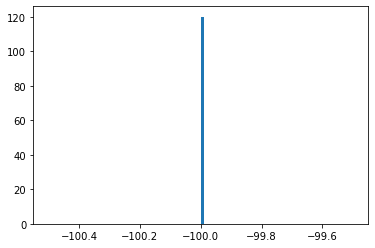

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a4465621_3_3_1_float.hdf5


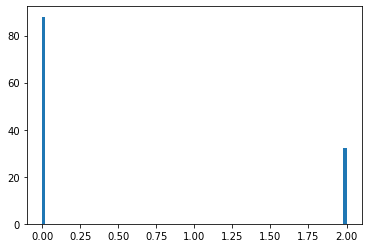

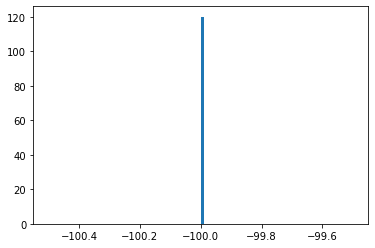

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a13291891_2_1_0_float.hdf5


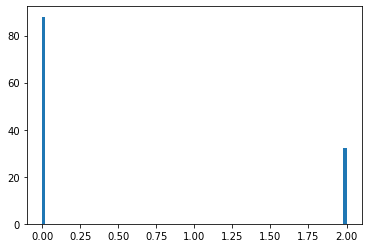

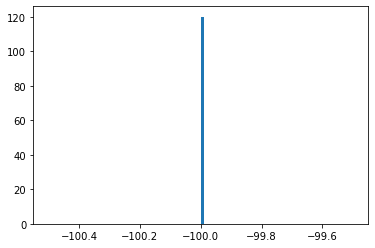

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a12790580_1_3_1_float.hdf5


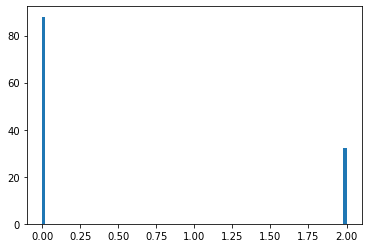

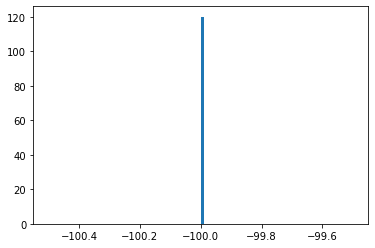

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a3363772_2_2_0_float.hdf5


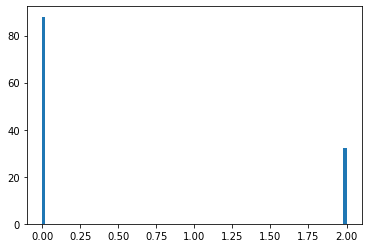

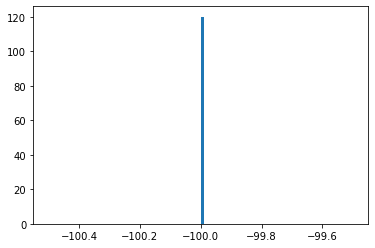

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a13179063_0_3_2_float.hdf5


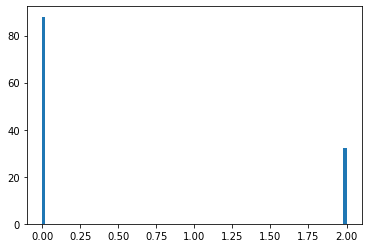

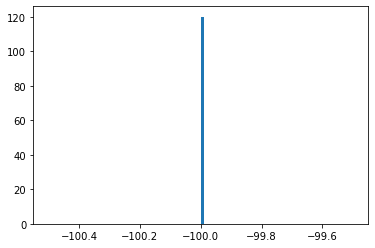

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a11952311_3_3_3_float.hdf5


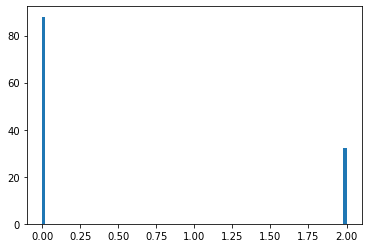

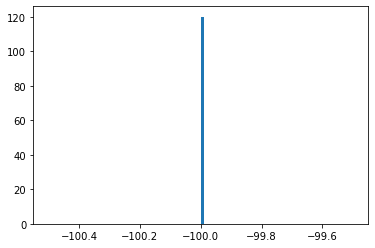

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a5550606_0_2_2_float.hdf5


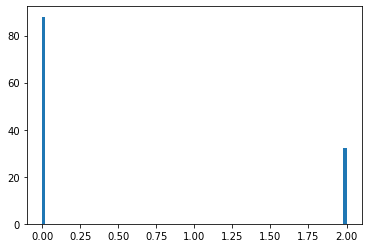

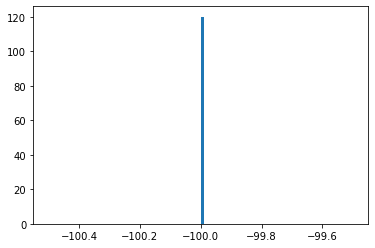

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a6900240_3_3_2_float.hdf5


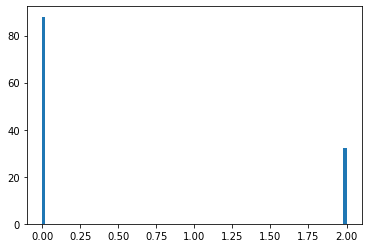

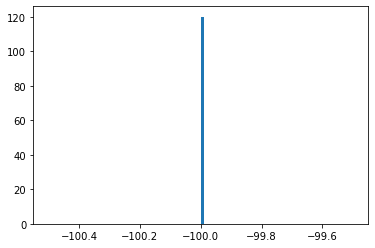

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a6235854_3_1_0_float.hdf5


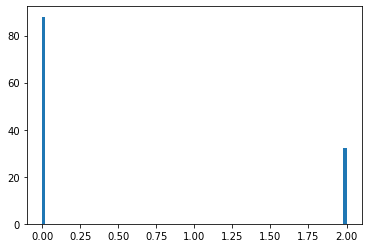

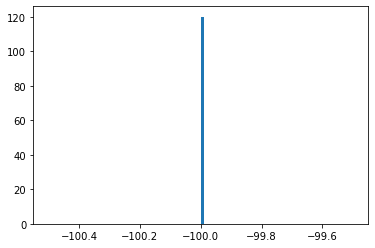

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a6343427_3_1_1_float.hdf5


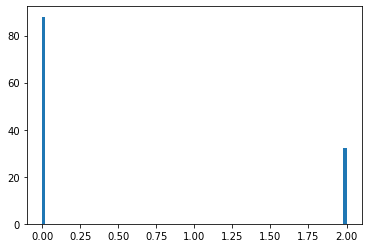

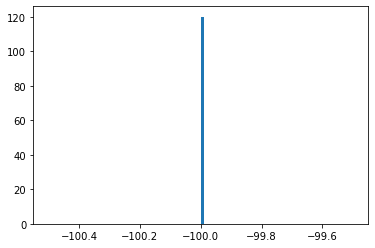

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a413623_1_0_0_float.hdf5


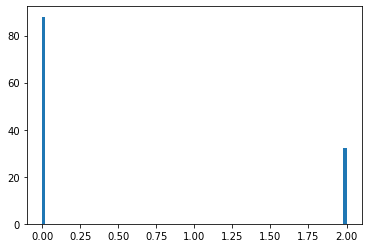

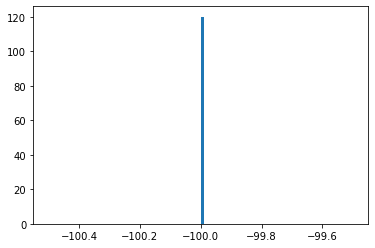

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a13201448_3_2_0_float.hdf5


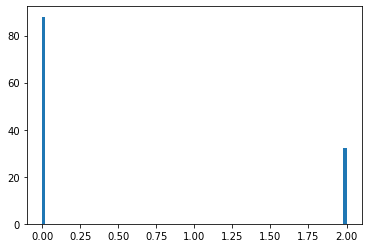

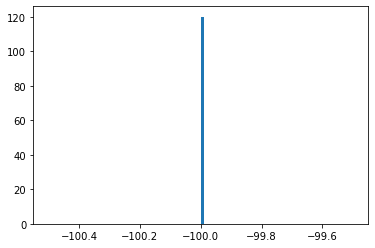

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a2766630_3_2_2_float.hdf5


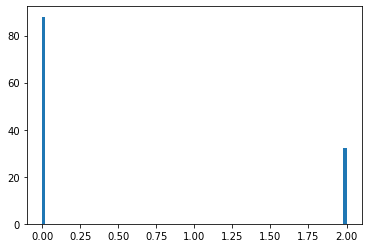

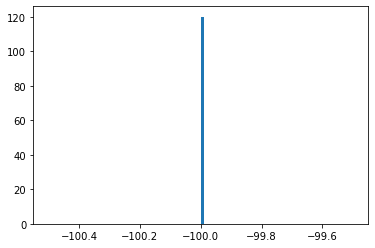

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a11861240_2_0_1_float.hdf5


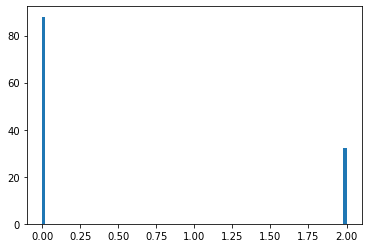

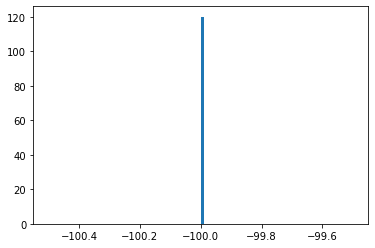

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a14140796_3_2_0_float.hdf5


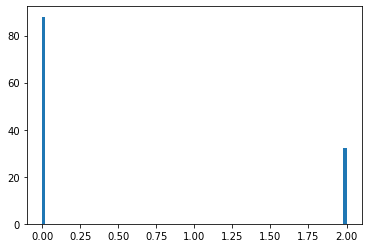

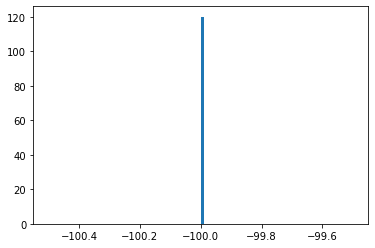

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a15087358_1_2_2_float.hdf5


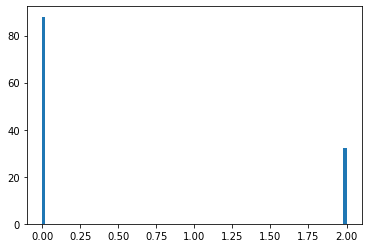

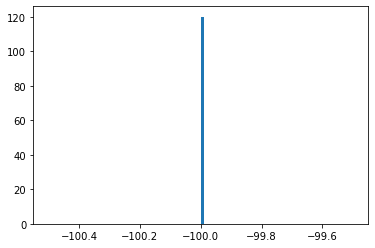

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a16681114_3_3_2_float.hdf5


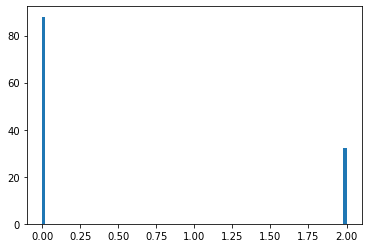

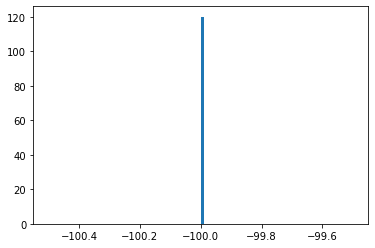

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a6776813_0_3_2_float.hdf5


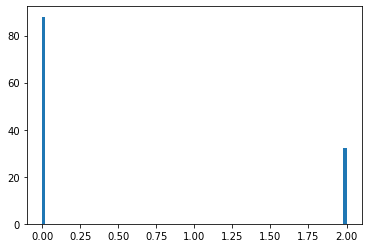

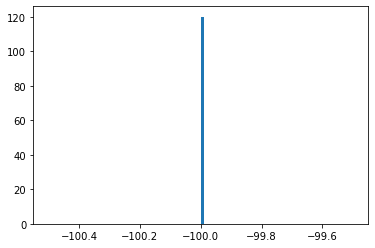

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a12659300_1_0_2_float.hdf5


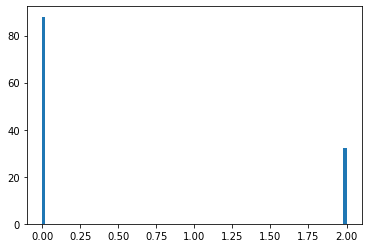

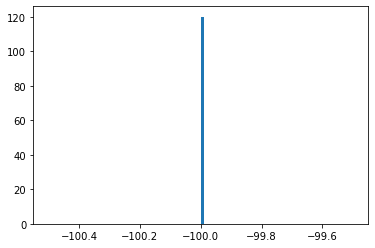

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a16627071_1_1_1_float.hdf5


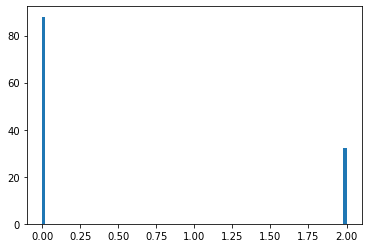

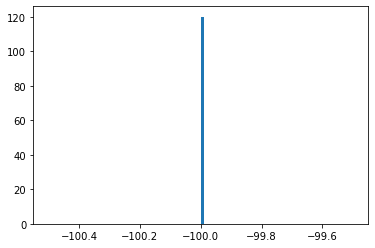

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a1570076_1_0_0_float.hdf5


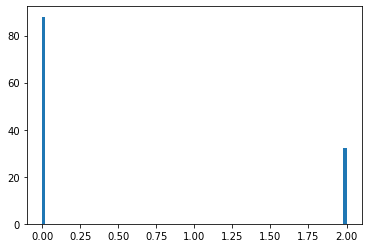

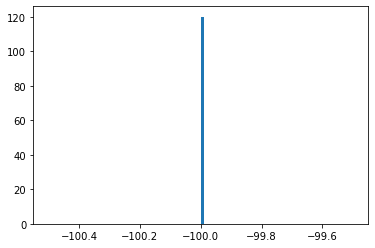

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a5933743_0_2_2_float.hdf5


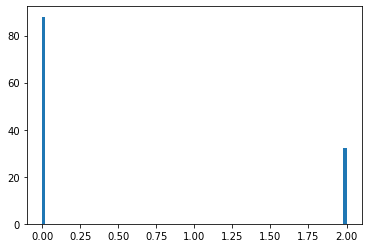

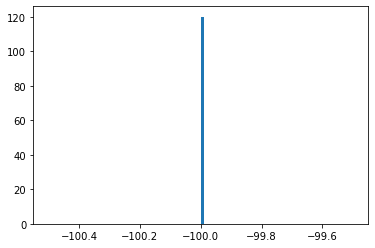

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a1702282_3_1_3_float.hdf5


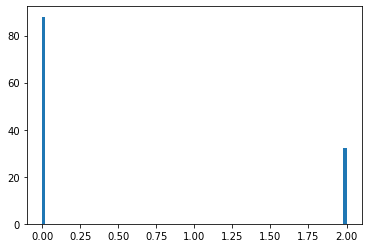

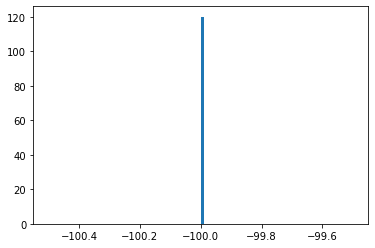

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a16767807_2_0_2_float.hdf5


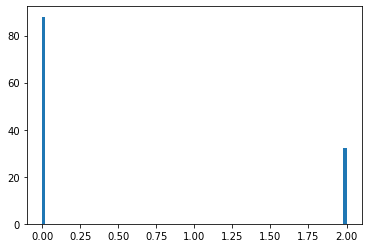

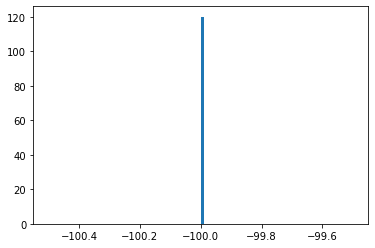

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a10032141_3_3_1_float.hdf5


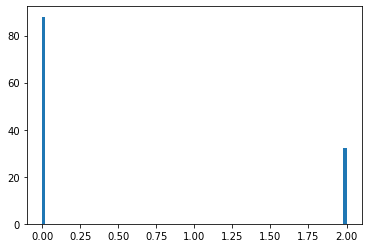

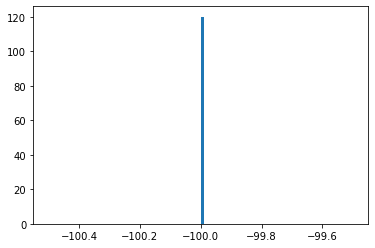

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a2416285_0_1_3_float.hdf5


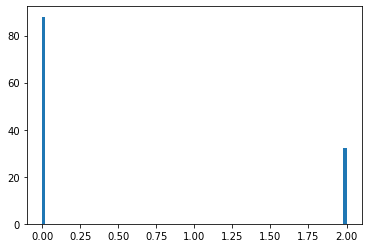

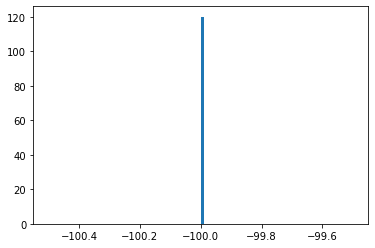

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a2952175_2_1_2_float.hdf5


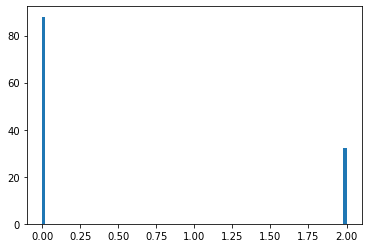

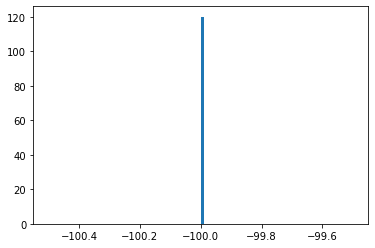

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a3615299_3_2_2_float.hdf5


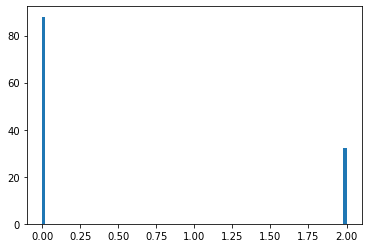

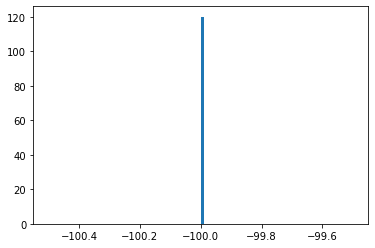

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a5513339_1_2_2_float.hdf5


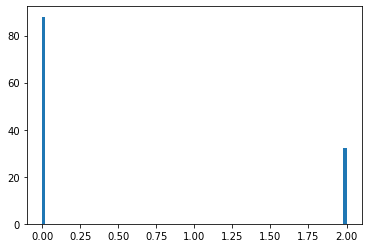

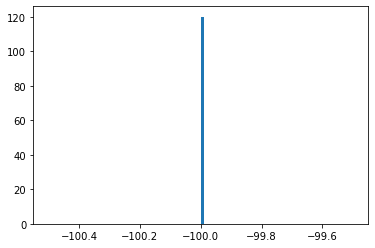

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a14831531_1_2_1_float.hdf5


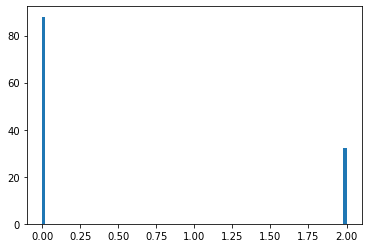

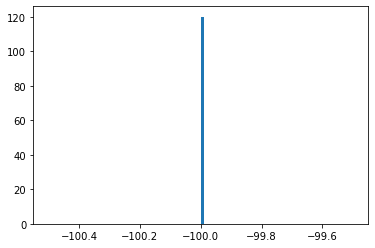

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a12330502_3_2_2_float.hdf5


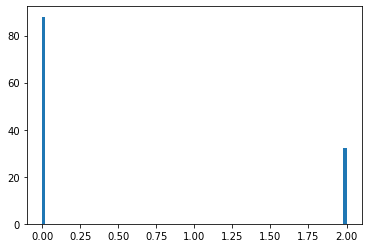

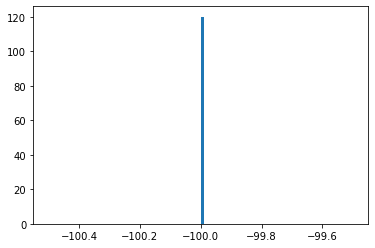

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a14965258_1_0_1_float.hdf5


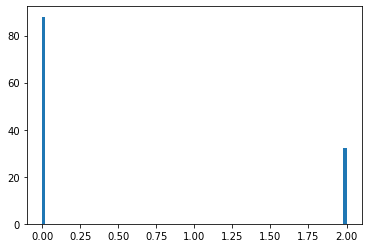

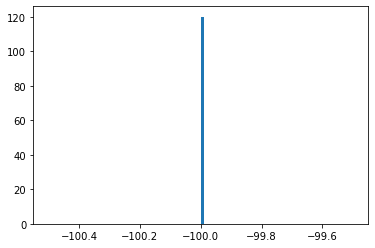

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a13349234_1_3_1_float.hdf5


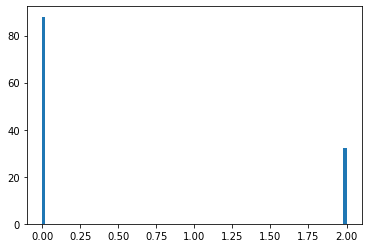

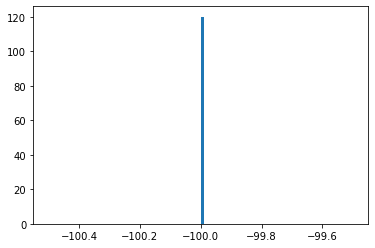

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a4732358_1_0_2_float.hdf5


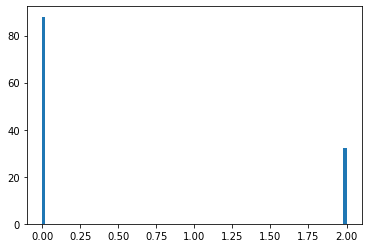

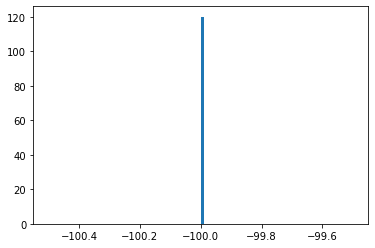

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a15714011_2_0_1_float.hdf5


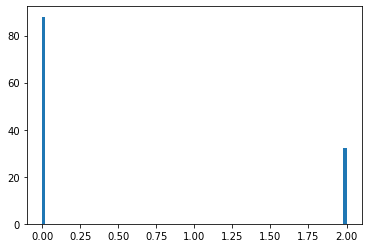

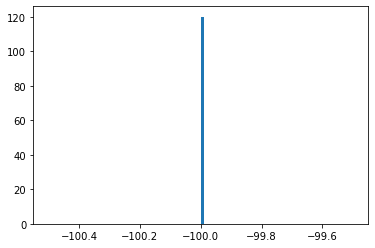

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a2412060_1_3_3_float.hdf5


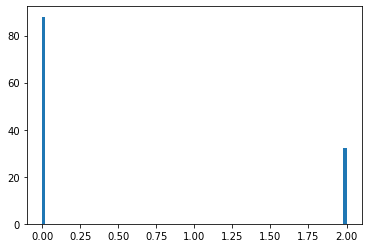

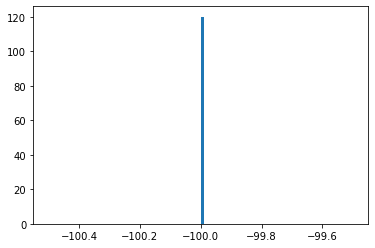

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a3713426_1_1_1_float.hdf5


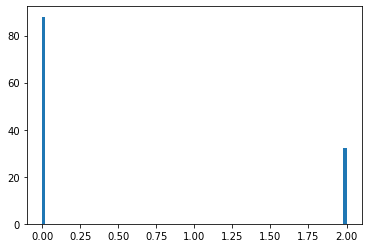

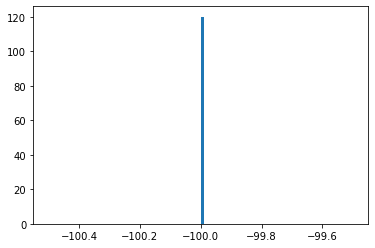

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a5002559_1_2_3_float.hdf5


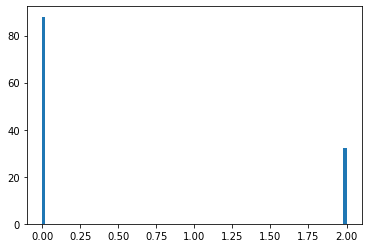

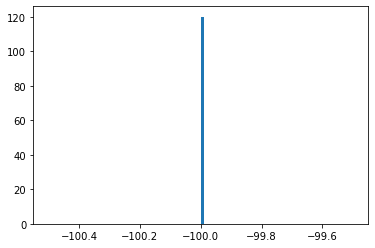

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a2445426_3_3_2_float.hdf5


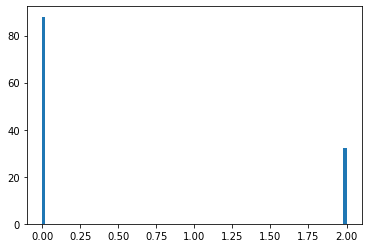

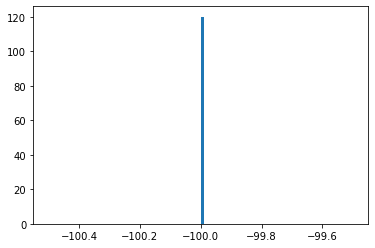

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a6863086_2_2_1_float.hdf5


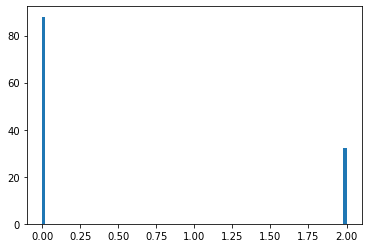

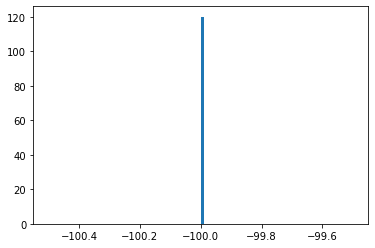

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a5245828_3_0_3_float.hdf5


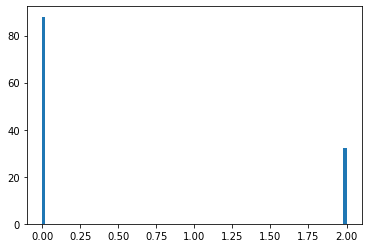

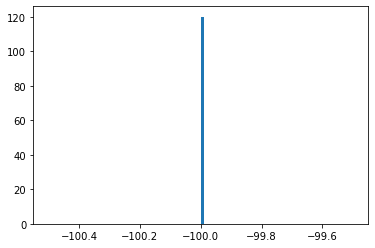

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a16031116_1_2_0_float.hdf5


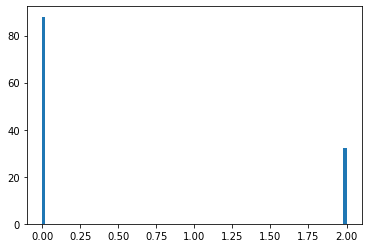

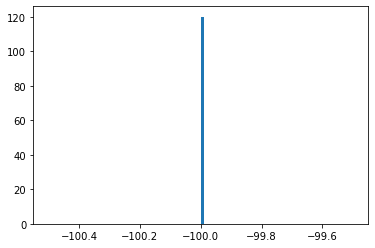

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a3837086_3_1_2_float.hdf5


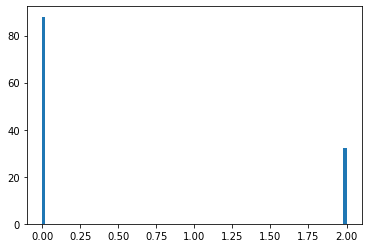

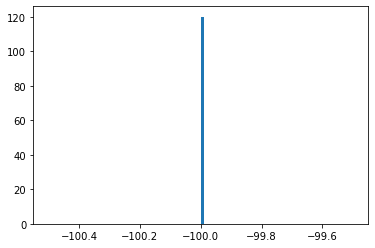

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a11834333_3_2_1_float.hdf5


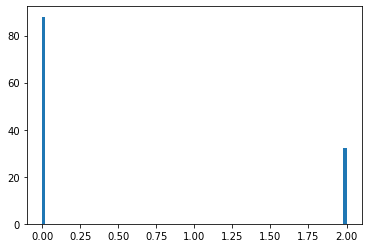

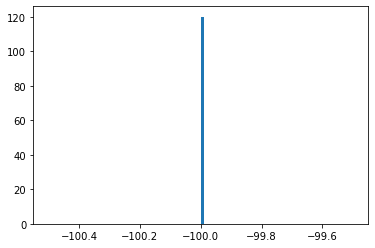

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a16689903_2_2_1_float.hdf5


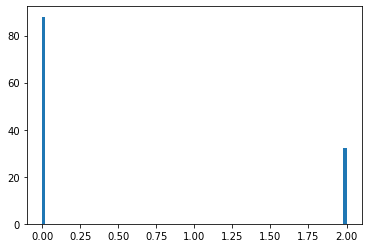

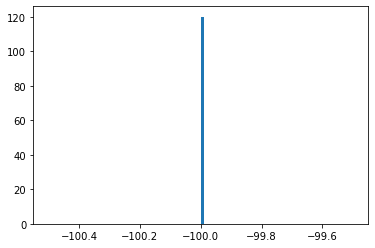

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a15954756_2_2_3_float.hdf5


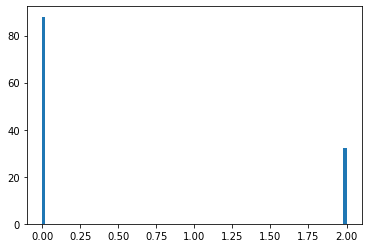

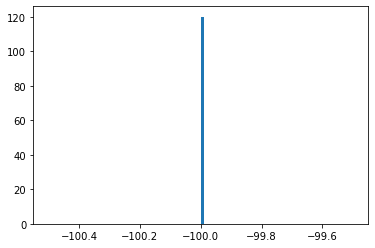

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a16397651_1_3_1_float.hdf5


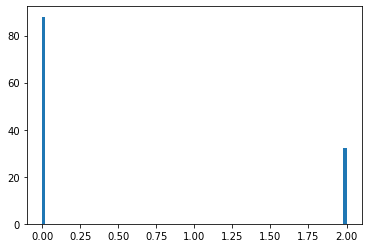

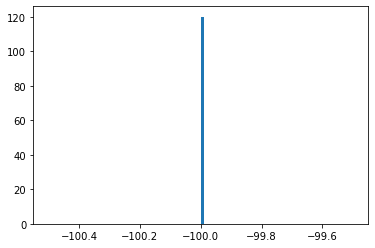

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a5263184_2_1_3_float.hdf5


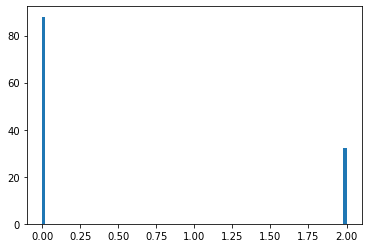

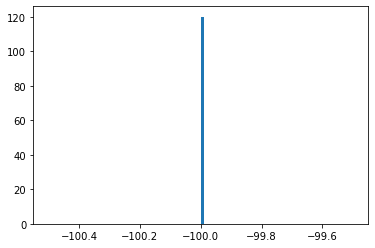

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a16246388_0_1_2_float.hdf5


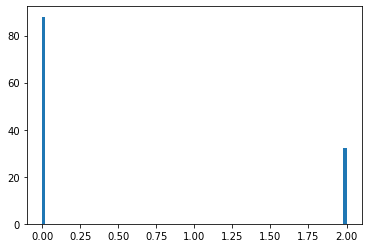

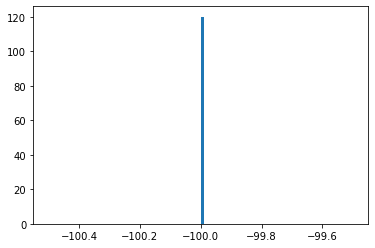

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a5462888_2_0_3_float.hdf5


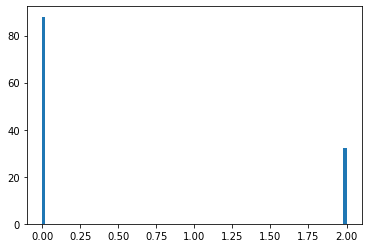

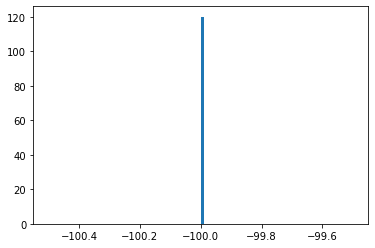

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a3200017_1_3_3_float.hdf5


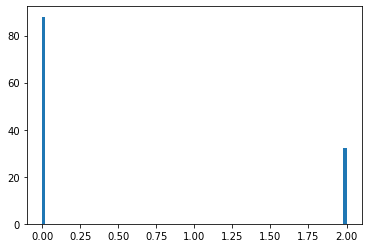

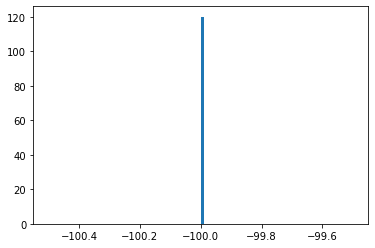

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a12239741_2_1_1_float.hdf5


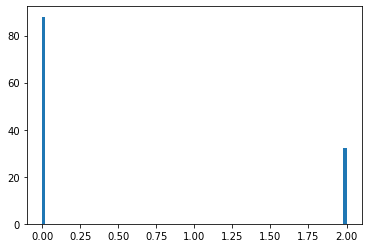

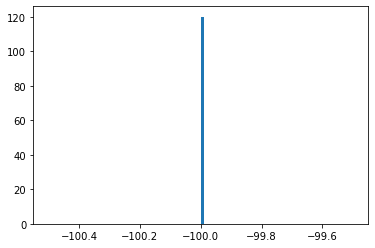

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a15462905_0_0_0_float.hdf5


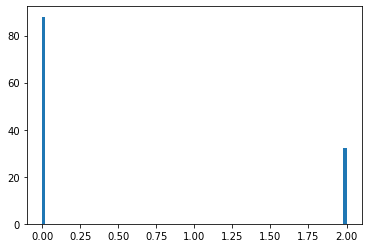

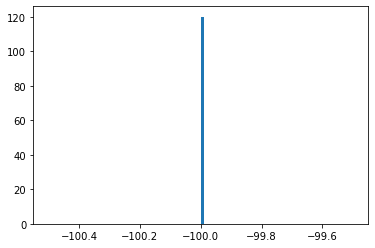

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a4513834_3_2_2_float.hdf5


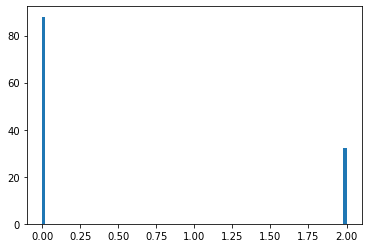

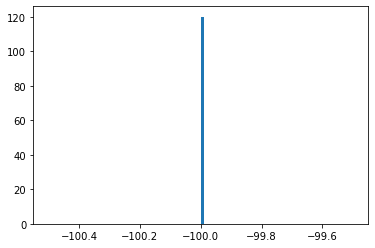

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a5150041_3_0_0_float.hdf5


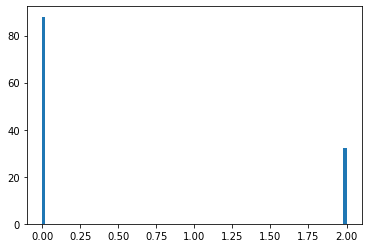

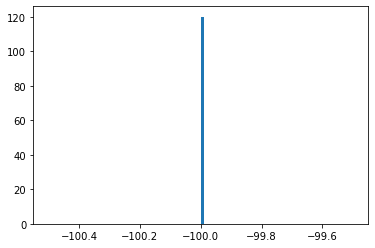

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a16175495_2_0_0_float.hdf5


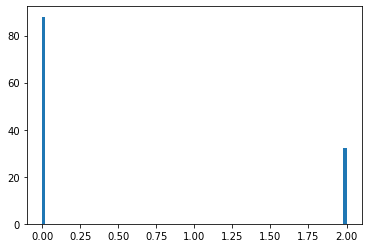

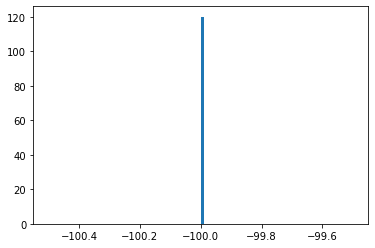

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a14533019_1_0_1_float.hdf5


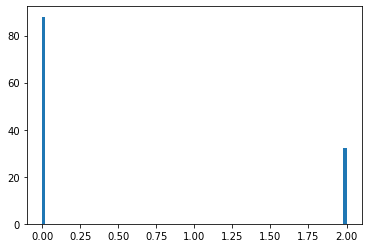

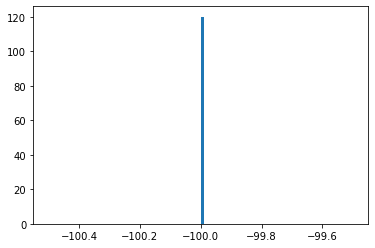

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a16480498_1_2_2_float.hdf5


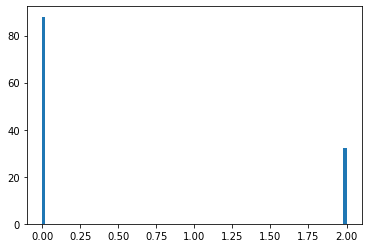

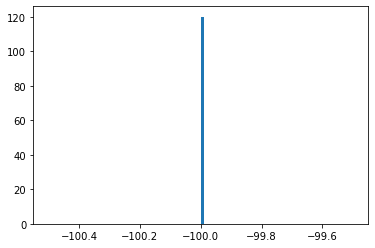

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a16034771_2_0_3_float.hdf5


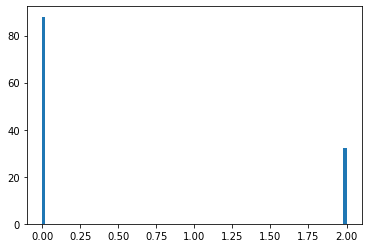

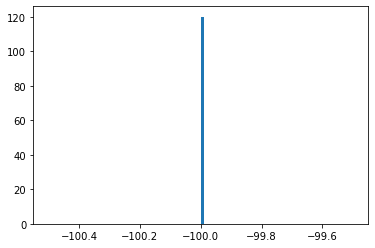

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a2225335_2_3_0_float.hdf5


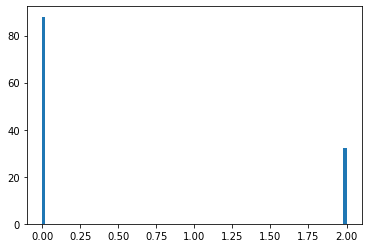

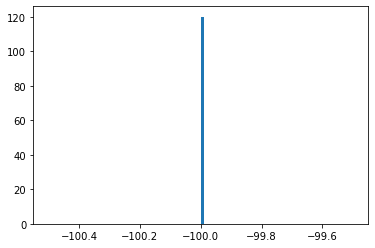

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a13349234_1_2_1_float.hdf5


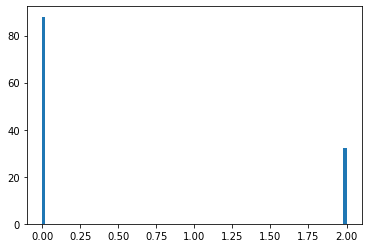

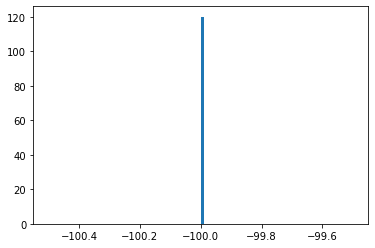

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a10806786_1_2_0_float.hdf5


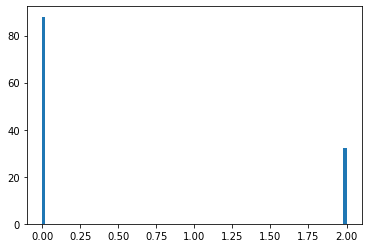

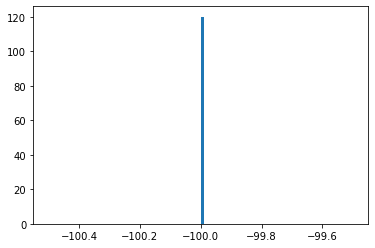

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a3201029_1_3_0_float.hdf5


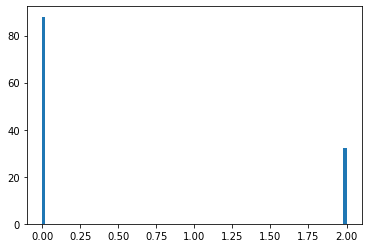

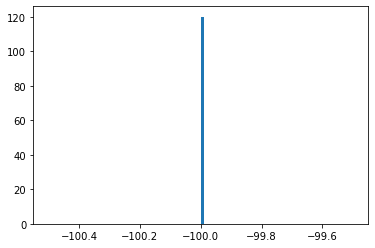

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a3366356_1_1_2_float.hdf5


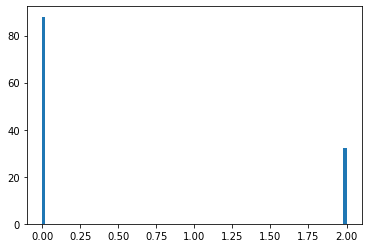

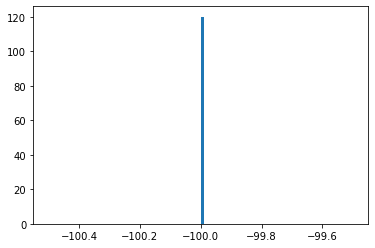

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a4781528_1_1_3_float.hdf5


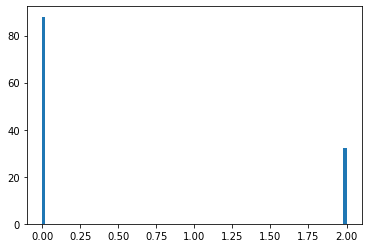

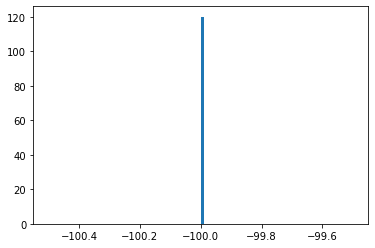

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a5294635_2_1_3_float.hdf5


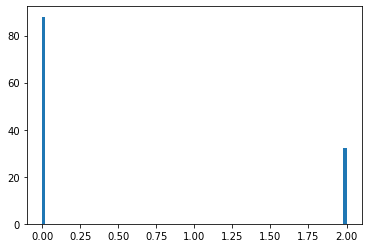

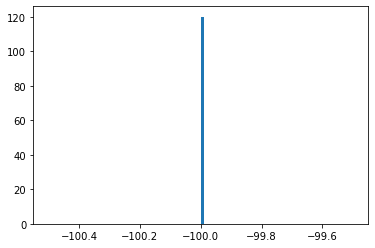

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a13820835_1_2_0_float.hdf5


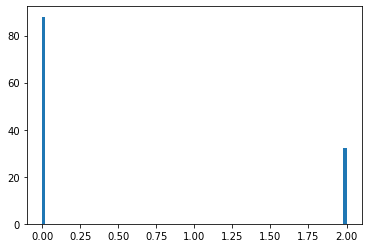

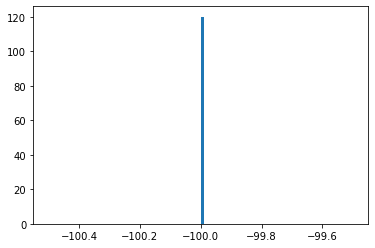

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a15616599_3_0_1_float.hdf5


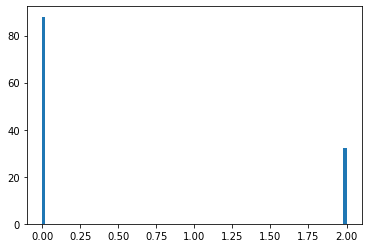

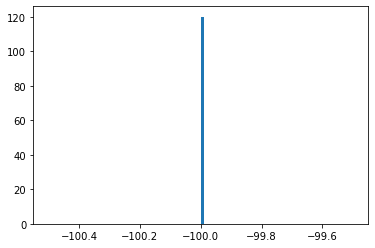

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a13988645_2_0_3_float.hdf5


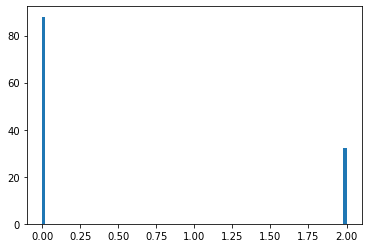

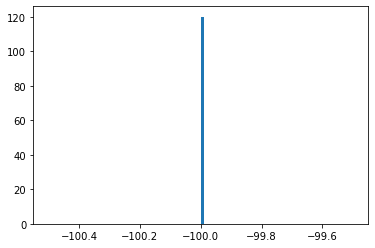

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a10105661_1_1_0_float.hdf5


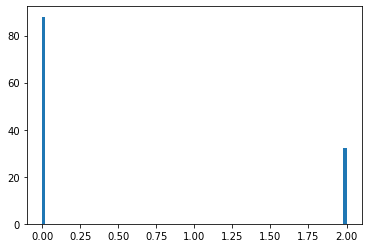

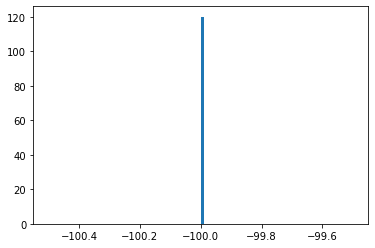

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a1347105_1_1_1_float.hdf5


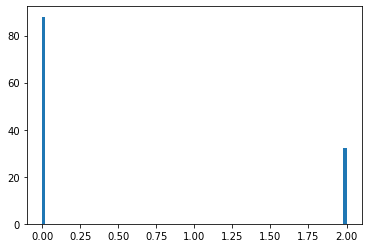

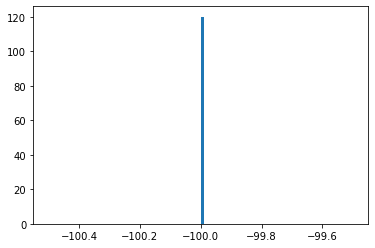

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a659335_0_3_3_float.hdf5


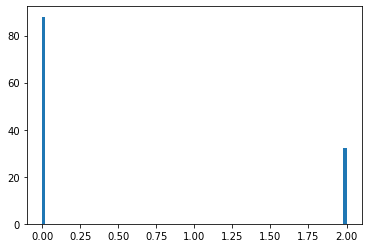

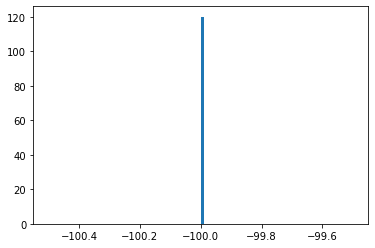

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a4132673_2_0_1_float.hdf5


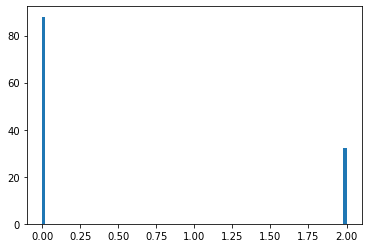

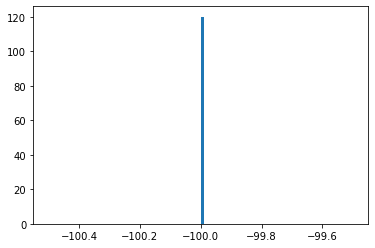

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a4188226_1_2_0_float.hdf5


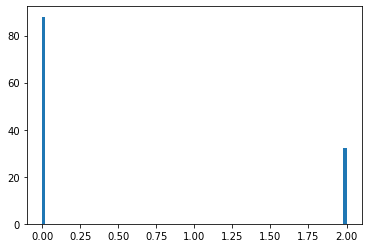

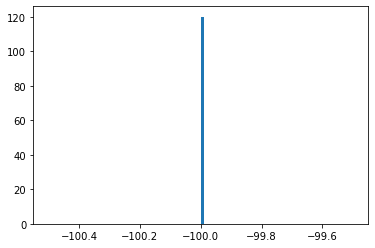

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a4713276_2_2_2_float.hdf5


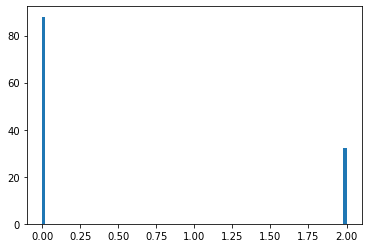

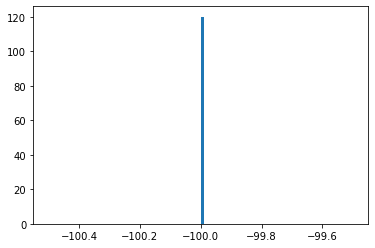

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a6796500_0_3_3_float.hdf5


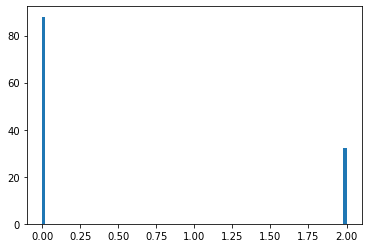

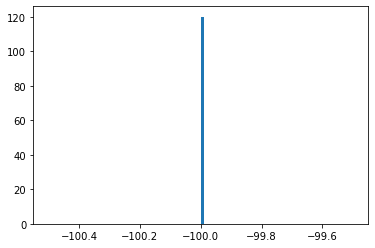

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a10964484_2_3_0_float.hdf5


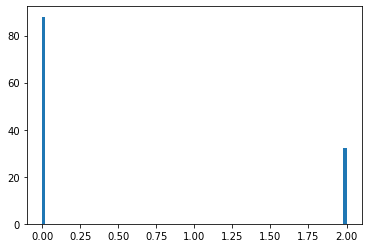

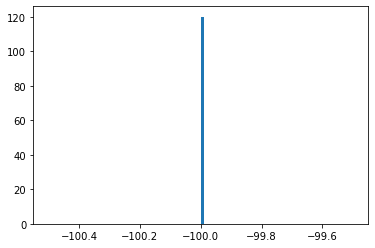

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a16138256_1_3_2_float.hdf5


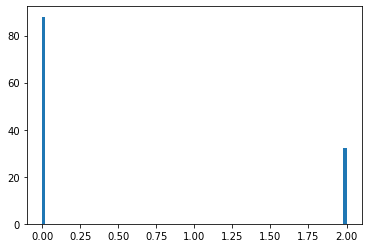

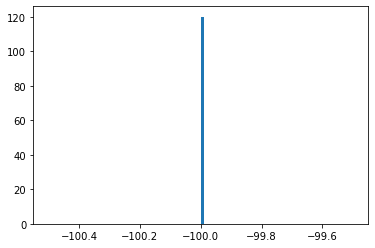

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a15209654_0_1_0_float.hdf5


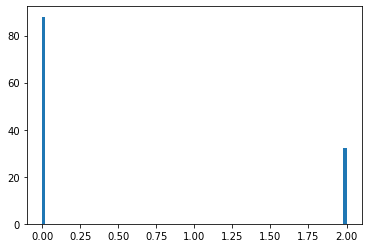

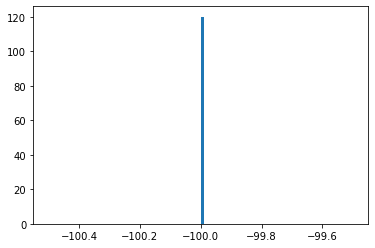

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a13789102_3_0_1_float.hdf5


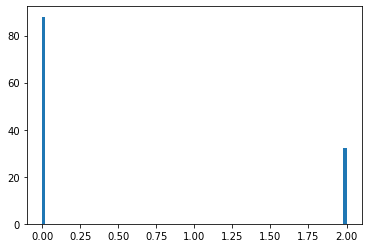

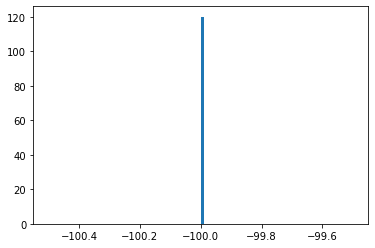

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a14894097_0_3_3_float.hdf5


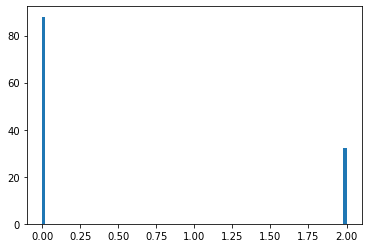

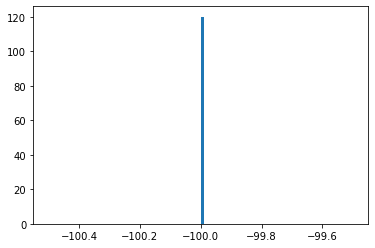

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a152056_1_0_1_float.hdf5


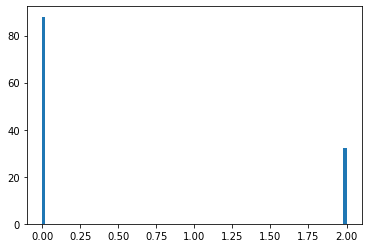

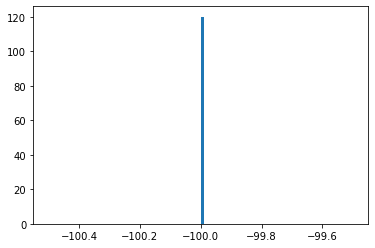

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a1958959_2_3_1_float.hdf5


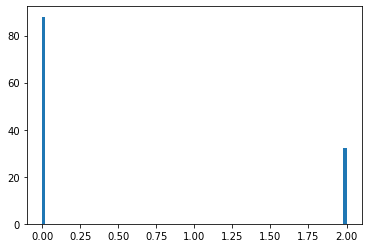

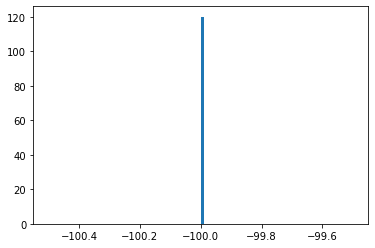

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a15136671_3_2_0_float.hdf5


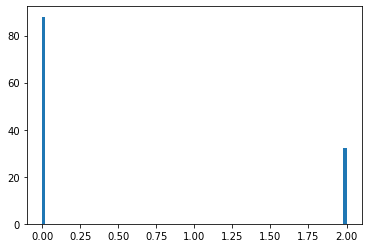

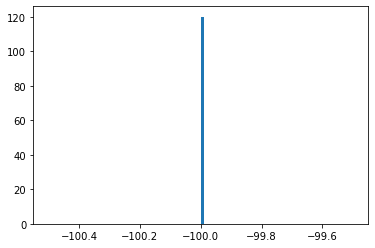

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a3958629_3_1_2_float.hdf5


KeyboardInterrupt: 

In [50]:
for filename in relevant_filenames:
    print(filename)
    file_df_temp = file_df[file_df['filename'] == filename] 
    file_sizes = file_df_temp['size'].to_numpy() / 1024.0 /1024.0
    plt.hist(file_sizes, bins=100)
    plt.show()
    plt.hist(file_df_temp['bandwidth'], bins=100)
    plt.show()